In [1]:
import scipy.io as sio
import numpy as np
from scipy.linalg import toeplitz
from scipy.linalg import eigh
from copy import deepcopy
from scipy.optimize import minimize
from scipy.stats import truncnorm
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import data_generator
import ESPRIT
import QPE
import QCELS
import GFOS

In [2]:
def generate_ts_distribution(T,N,gamma):
    """ Generate time samples from truncated Gaussian
    Input:
    
    T : variance of Gaussian
    gamma : truncated parameter
    N : number of samples
    
    Output: 
    
    t_list: np.array of time points
    """
    t_list=truncnorm.rvs(-gamma, gamma, loc=0, scale=T, size=N)
    return t_list

def generate_Z(spectrum,population,T,N,gamma):
    """ Generate Z samples for a given T,N,gamma
    Input:
    
    spectrum: np.array of eigenvalues
    population: np.array of overlap
    T : variance of Gaussian
    N : number of time samples
    gamma : truncated parameter
    
    Output: 
    
    Z_est: np.array of Z output
    t_list: np.array of time points
    T_max: maximal running time
    T_total: total running time
    """
    t_list = generate_ts_distribution(T,N,gamma)
    N_list = np.ones(len(t_list))
    T_max = max(np.abs(t_list))
    T_total = sum(np.multiply(np.abs(t_list),N_list))
    Z_est, _ , _ =data_generator.generate_Hadamard_test_data(spectrum,population,t_list,N_list)
    return Z_est, t_list, T_max, T_total

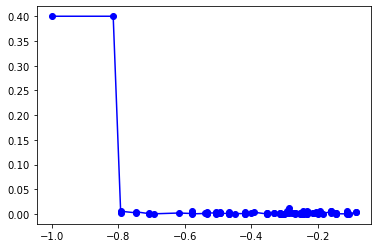

In [3]:
#Test TFIM
L = 8
J = 1.0
g = 4.0
p_list=np.array([0.4,0.4])
d=100

spectrum, population=data_generator.generate_initial_TFIM(L,J,g,p_list,d)

# Test GFOS

In [4]:
T_list=np.array([100,200,400,800,1600,3200,6400,12800])
N=500
K=2
alpha=5
gamma=1
error_GFOS=np.zeros(len(T_list),dtype='float')
T_total_GFOS=np.zeros(len(T_list),dtype='float')
for k in range(len(T_list)):
    T_max=T_list[k]
    d_x=0.05/T_max
    Z_est,t_list, _, T_total = generate_Z(spectrum,population,T_max,N,gamma)
    T_total_GFOS[k]=sum(np.abs(t_list))
    output_energy = GFOS.GFOS(Z_est, d_x, t_list, K, alpha, T_max)
    output_energy = np.sort(output_energy)
    ##---measure error--##
    index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
    dominant_energy=np.zeros(K,dtype=float)
    dominant_weight=np.zeros(K,dtype=float)
    for l in range(K):
            dominant_energy[l]=spectrum[index_list[l]]
            error_GFOS[k]=max(error_GFOS[k],min(np.abs(dominant_energy[l]-output_energy)))
    print('Tmax=',gamma*T_max)
    print('Output of GFOS energy=',output_energy)
    print('True dominant=',np.sort(dominant_energy))

Tmax= 100
Output of GFOS energy= [-1.00309265 -0.81409265]
True dominant= [-1.         -0.81539519]
Tmax= 200
Output of GFOS energy= [-1.00134265 -0.81409265]
True dominant= [-1.         -0.81539519]
Tmax= 400
Output of GFOS energy= [-0.99959265 -0.81671765]
True dominant= [-1.         -0.81539519]
Tmax= 800
Output of GFOS energy= [-1.00009265 -0.81584265]
True dominant= [-1.         -0.81539519]
Tmax= 1600
Output of GFOS energy= [-1.0000614 -0.8154989]
True dominant= [-1.         -0.81539519]
Tmax= 3200
Output of GFOS energy= [-1.00001453 -0.81538953]
True dominant= [-1.         -0.81539519]
Tmax= 6400
Output of GFOS energy= [-1.00004578 -0.81539734]
True dominant= [-1.         -0.81539519]
Tmax= 12800
Output of GFOS energy= [-0.99997156 -0.81540906]
True dominant= [-1.         -0.81539519]


# Test QPE

In [5]:
N_QPE=30
error_QPE=np.zeros(len(T_list),dtype='float')
T_total_QPE=np.zeros(len(T_list),dtype='float')
for k in range(len(T_list)):
    T_max=T_list[k]
    output_energy = QPE.QPE(spectrum,population,T_max,N_QPE)
    T_total_QPE[k]=T_max*N_QPE
    ##---measure error--##
    error_QPE[k]=np.abs(spectrum[0]-output_energy)
    print('Tmax=',T_max)
    print('Output of QPE energy=',output_energy)
    print('True ground=',spectrum[0])

Tmax= 100
Output of QPE energy= -1.0053096491487334
True ground= -1.0
Tmax= 200
Output of QPE energy= -1.0053096491487334
True ground= -1.0
Tmax= 400
Output of QPE energy= -1.0210176124166828
True ground= -1.0
Tmax= 800
Output of QPE energy= -1.060287520586555
True ground= -1.0
Tmax= 1600
Output of QPE energy= -1.0053096491487334
True ground= -1.0
Tmax= 3200
Output of QPE energy= -1.0053096491487334
True ground= -1.0
Tmax= 6400
Output of QPE energy= -1.0092366399657209
True ground= -1.0
Tmax= 12800
Output of QPE energy= -0.9999100367753764
True ground= -1.0


# Test ESPRIT

In [6]:
t_list=np.arange(max(T_list))
N_list=np.ones(len(t_list))
f_values,_,_=data_generator.generate_Hadamard_test_data(spectrum,population,t_list,N_list)
K_ESPRIT=2
K_dominant=2
nt_array=T_list
error_ESPRIT=np.zeros(len(nt_array),dtype='float')
T_total_ESPRIT=np.zeros(len(T_list),dtype='float')
for k in range(len(nt_array)):
    dt=1
    nt_effective=nt_array[k]
    #ESPRIT
    output_energy = ESPRIT.ESPRIT(f_values[:nt_effective], int(nt_effective/2), nt_effective, K_ESPRIT)
    T_total_ESPRIT[k]=nt_effective*(nt_effective+1)/2
    ##---measure error--##
    index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
    dominant_energy=np.zeros(K_dominant,dtype=float)
    dominant_weight=np.zeros(K_dominant,dtype=float)
    for l in range(K_dominant):
            dominant_energy[l]=spectrum[index_list[l]]
            error_ESPRIT[k]=max(error_ESPRIT[k],min(np.abs(dominant_energy[l]-output_energy)))
    print('Tmax=',nt_effective*dt)
    print('Output of ESPRIT energy=',output_energy)
    print('True dominant=',np.sort(dominant_energy))

Tmax= 100
Output of ESPRIT energy= [-1.020848   -0.78187746]
True dominant= [-1.         -0.81539519]
Tmax= 200
Output of ESPRIT energy= [-0.9943778  -0.80656315]
True dominant= [-1.         -0.81539519]
Tmax= 400
Output of ESPRIT energy= [-1.00073534 -0.81596489]
True dominant= [-1.         -0.81539519]
Tmax= 800
Output of ESPRIT energy= [-1.00027101 -0.81512494]
True dominant= [-1.         -0.81539519]
Tmax= 1600
Output of ESPRIT energy= [-0.99970996 -0.81547806]
True dominant= [-1.         -0.81539519]
Tmax= 3200
Output of ESPRIT energy= [-0.99998242 -0.81548932]
True dominant= [-1.         -0.81539519]
Tmax= 6400
Output of ESPRIT energy= [-1.00000521 -0.81541529]
True dominant= [-1.         -0.81539519]
Tmax= 12800
Output of ESPRIT energy= [-1.00000073 -0.81539741]
True dominant= [-1.         -0.81539519]


# Test QCELS

In [7]:
def spectrum_organize(Output_QCELS): #combine opposite r but same \theta
    dis_threshold=0.01
    L=len(Output_QCELS)
    L=int(L/3)
    index_list=np.zeros(L, dtype='float')
    weight_rearrange=np.zeros(L, dtype='complex')
    indicator=np.zeros(L, dtype='float')
    for l in range(L): #combine eigenvalues with oppposite weight
        if indicator[l]==0:
           weight_rearrange[l]=Output_QCELS[3*l]+1j*Output_QCELS[3*l+1]
           fix_energy_check=Output_QCELS[3*l+2]
           for j in range(l+1,L): 
               if np.abs(Output_QCELS[3*j+2]-fix_energy_check)<dis_threshold:
                  weight_rearrange[l]+=Output_QCELS[3*j]+1j*Output_QCELS[3*j+1]
                  indicator[j]=1
        indicator[l]=1
        weight_rearrange[l]=np.abs(weight_rearrange[l])
    index_list=sorted(range(L),key= lambda k:weight_rearrange[k], reverse=True)
    dominant_energy=np.zeros(L, dtype='float')
    for l in range(L):
        dominant_energy[l]=Output_QCELS[3*index_list[l]+2]
    return dominant_energy

In [8]:
error_QCELS=np.zeros(len(T_list),dtype='float')
N_0 = 1000 #N_0
N = 1000 #N
gamma=1
K_QCELS=2
T_total_QCELS=np.zeros(len(T_list),dtype='float')
for k in range(len(T_list)):
    T = T_list[k]
    T_0 = 100
    dominant_energy_estimate=np.zeros(K_QCELS)
    Output_QCELS, _, T_total = \
             QCELS.qcels_multimodal(spectrum, population, T_0, T, N_0, N, gamma, K_QCELS, spectrum[0:2])#QCELS with time T
    output_energy=np.sort(spectrum_organize(Output_QCELS))
    T_total_QCELS[k]=T_total
    ##---measure error--##
    index_list=sorted(range(len(population)),key= lambda k:population[k], reverse=True)
    dominant_energy=np.zeros(K_dominant,dtype=float)
    dominant_weight=np.zeros(K_dominant,dtype=float)
    for l in range(K_dominant):
            dominant_energy[l]=spectrum[index_list[l]]
            error_QCELS[k]=max(error_QCELS[k],min(np.abs(dominant_energy[l]-output_energy)))
    print('Tmax=',gamma*T)
    print('Output of QCELS energy=',output_energy)
    print('True dominant=',np.sort(dominant_energy))

Tmax= 100
Output of QCELS energy= [-1.00046332 -0.81359786]
True dominant= [-1.         -0.81539519]
Tmax= 200
Output of QCELS energy= [-0.99982326 -0.81436907]
True dominant= [-1.         -0.81539519]
Tmax= 400
Output of QCELS energy= [-0.99953789 -0.81521635]
True dominant= [-1.         -0.81539519]
Tmax= 800
Output of QCELS energy= [-0.99990938 -0.81524345]
True dominant= [-1.         -0.81539519]
Tmax= 1600
Output of QCELS energy= [-0.99995124 -0.81538085]
True dominant= [-1.         -0.81539519]
Tmax= 3200
Output of QCELS energy= [-1.00003464 -0.81543058]
True dominant= [-1.         -0.81539519]
Tmax= 6400
Output of QCELS energy= [-0.99997695 -0.81538527]
True dominant= [-1.         -0.81539519]
Tmax= 12800
Output of QCELS energy= [-0.99999066 -0.81539549]
True dominant= [-1.         -0.81539519]


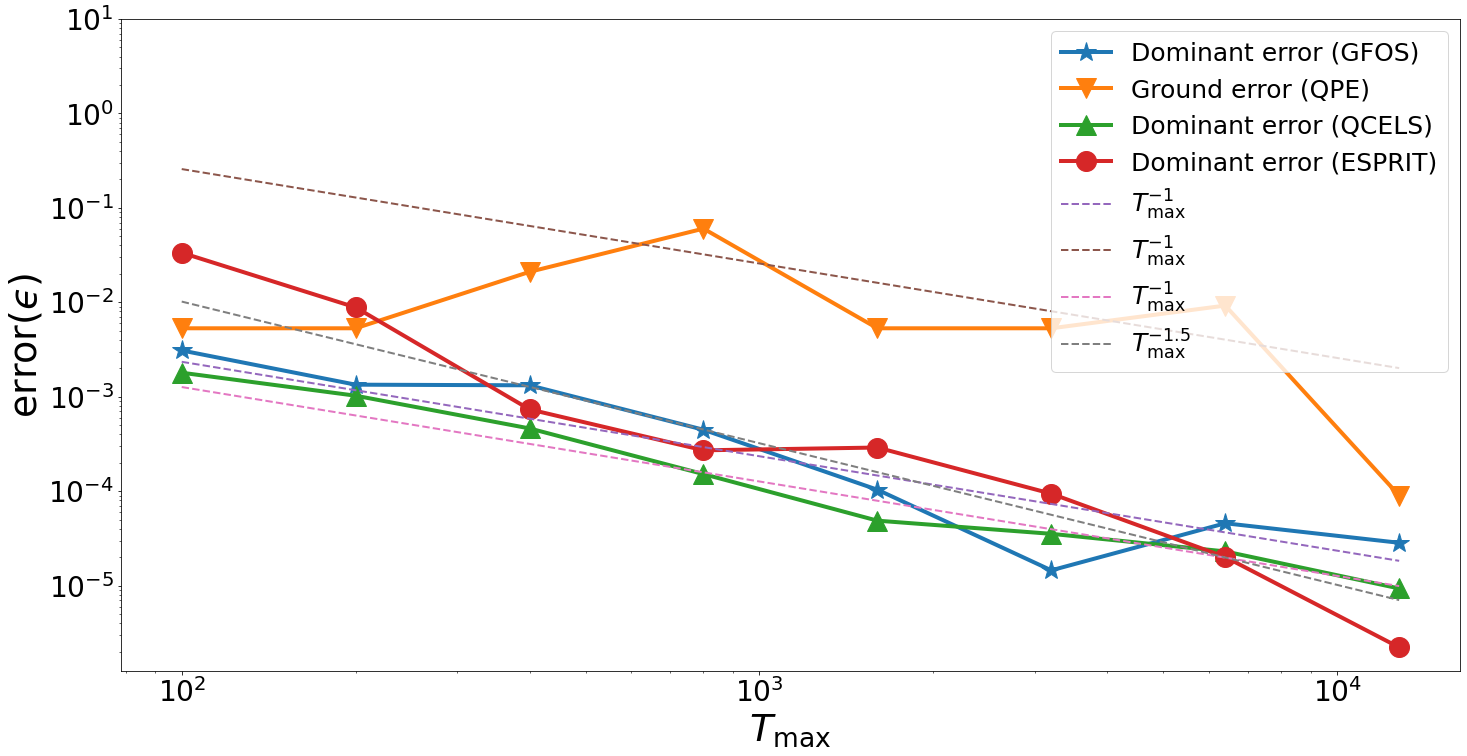

In [12]:
# Plotting the real and imaginary parts of f(t)
T_list=dt*nt_array
plt.figure(figsize=(24, 12))
plt.loglog(T_list, error_GFOS, marker="*",markersize=20,
           linewidth=4, label='Dominant error (GFOS)')
plt.loglog(T_list, error_QPE, marker="v",markersize=20,
            linewidth=4, label='Ground error (QPE)')
plt.loglog(T_list, error_QCELS, marker="^",markersize=20,
           linewidth=4, label='Dominant error (QCELS)')
plt.loglog(T_list, error_ESPRIT, marker="o",markersize=20,
           linewidth=4, label='Dominant error (ESPRIT)')
plt.loglog(T_list, np.dot(error_GFOS[5:],T_list[5:])/T_list/len(error_GFOS[5:]), 
           '--', linewidth=2, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_QPE[5:],T_list[5:])/T_list/len(error_QPE[5:]), 
            '--', linewidth=2, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_QCELS[5:],T_list[5:])/T_list/len(error_QCELS[5:]),
           '--', linewidth=2, label=r'$T_{\max}^{-1}$')
plt.loglog(T_list, np.dot(error_ESPRIT[5:],T_list[5:]**1.5)/T_list**1.5/len(error_ESPRIT[5:]), 
           '--', linewidth=2, label=r'$T_{\max}^{-1.5}$')
plt.xlabel("$T_{\max}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25,loc="upper right")

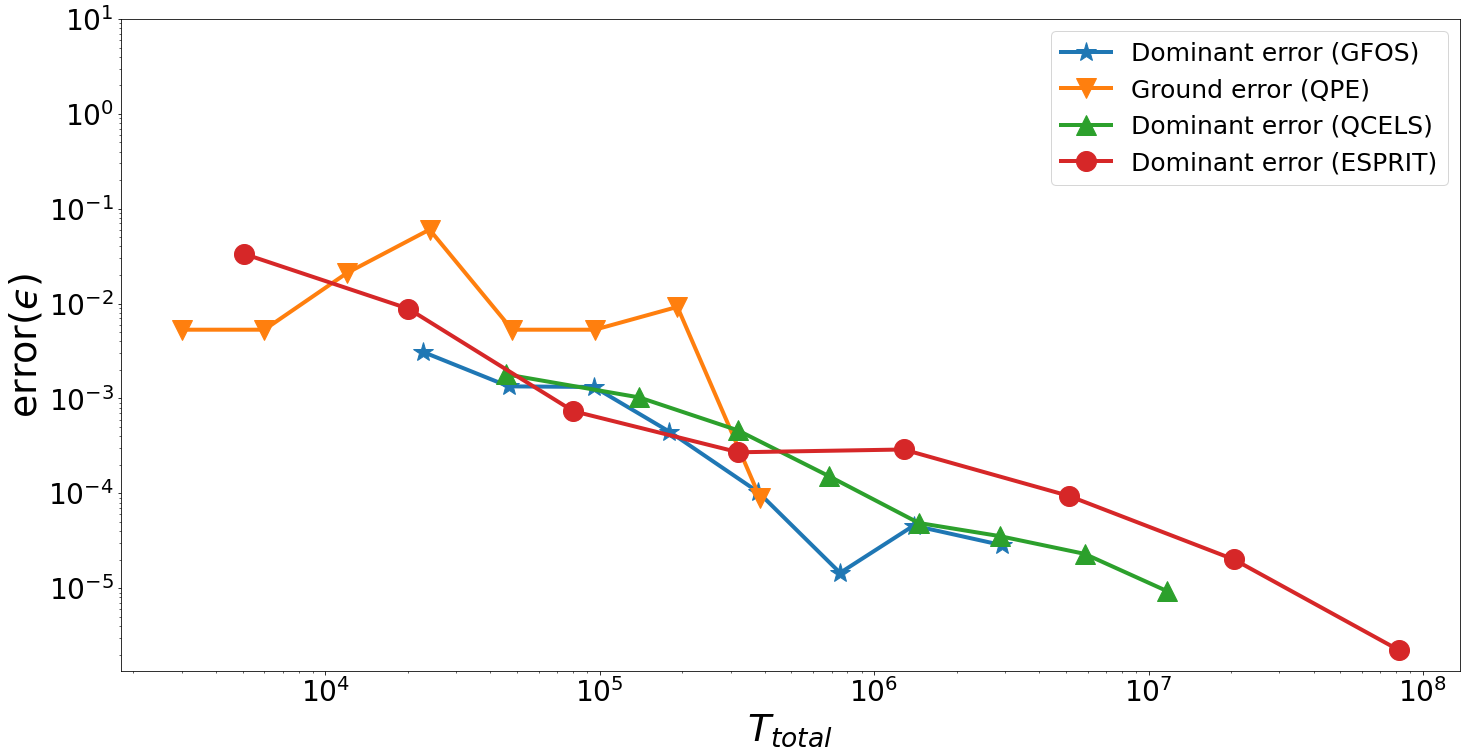

In [10]:
# Plotting the real and imaginary parts of f(t)
T_list=dt*nt_array
plt.figure(figsize=(24, 12))
plt.loglog(T_total_GFOS, error_GFOS, marker="*",markersize=20,
           linewidth=4, label='Dominant error (GFOS)')
plt.loglog(T_total_QPE, error_QPE, marker="v",markersize=20,
            linewidth=4, label='Ground error (QPE)')
plt.loglog(T_total_QCELS, error_QCELS, marker="^",markersize=20,
           linewidth=4, label='Dominant error (QCELS)')
plt.loglog(T_total_ESPRIT, error_ESPRIT, marker="o",markersize=20,
           linewidth=4, label='Dominant error (ESPRIT)')
plt.xlabel("$T_{total}$",fontsize=38)
plt.ylabel("error($ϵ$)",fontsize=38)
plt.xticks(fontsize=28)
plt.yticks(fontsize=28)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=25)